In [41]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats
import openpyxl

In [42]:
# Create the dataset
df = pd.read_csv('datasets/brazilian-fuel-dataset.tsv', sep='\t')

In [43]:
# Reset do display do pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', None)

In [44]:
# Delete columns COEF DE VARIAÇÃO DISTRIBUIÇÃO and DESVIO PADRÃO DISTRIBUIÇÃO and COEF DE VARIAÇÃO REVENDA and DESVIO PADRÃO REVENDA
df = df.drop(columns=['COEF DE VARIAÇÃO DISTRIBUIÇÃO', 'DESVIO PADRÃO DISTRIBUIÇÃO', 'COEF DE VARIAÇÃO REVENDA', 'DESVIO PADRÃO REVENDA', 'DATA FINAL'])

In [45]:
# Trocar formato da data de yyyy/mm/dd para dd/mm/yyyy
df['DATA INICIAL'] = pd.to_datetime(df['DATA INICIAL'])

df['DATA INICIAL'] = df['DATA INICIAL'].dt.strftime('%d/%m/%Y')


In [46]:
# Excluir registros que possuem somente "-" como valor
df.replace('-', pd.NA, inplace=True)
df.dropna(inplace=True)

In [47]:
# Transformar as colunas de valores em Float
cols_to_float = ['PREÇO MÉDIO REVENDA', 'PREÇO MÍNIMO REVENDA', 'PREÇO MÁXIMO REVENDA',
                 'MARGEM MÉDIA REVENDA', 'PREÇO MÉDIO DISTRIBUIÇÃO',
                 'PREÇO MÍNIMO DISTRIBUIÇÃO', 'PREÇO MÁXIMO DISTRIBUIÇÃO']
df[cols_to_float] = df[cols_to_float].replace(',', '.', regex=True).astype(float)

In [48]:
# Renomear colunas
df.rename(columns={'DATA INICIAL': 'data_inicial', 'REGIÃO': 'regiao',
                   'ESTADO': 'estado', 'PRODUTO': 'produto', 'NÚMERO DE POSTOS PESQUISADOS': 'num_postos',
                   'UNIDADE DE MEDIDA': 'unidade', 'PREÇO MÉDIO REVENDA': 'preco_medio_final',
                   'PREÇO MÍNIMO REVENDA': 'preco_min_final', 'PREÇO MÁXIMO REVENDA': 'preco_max_final',
                   'MARGEM MÉDIA REVENDA': 'margem_media_final', 'PREÇO MÉDIO DISTRIBUIÇÃO': 'preco_medio_atacado',
                   'PREÇO MÍNIMO DISTRIBUIÇÃO': 'preco_min_atacado', 'PREÇO MÁXIMO DISTRIBUIÇÃO': 'preco_max_atacado'}, inplace=True)

In [49]:
# Alterar os datatypes
df = df.astype({
    'data_inicial': 'object',
    'regiao': 'object',
    'estado': 'object',
    'produto': 'object',
    'num_postos': 'int64',
    'unidade': 'object',
    'preco_medio_final': 'float64',
    'preco_min_final': 'float64',
    'preco_max_final': 'float64',
    'margem_media_final': 'float64',
    'preco_medio_atacado': 'float64',
    'preco_min_atacado': 'float64',
    'preco_max_atacado': 'float64'
})

In [50]:
# Excluir linhas onde o preco_medio_revenda e margem_media_revenda são -99999.00
df = df[df['preco_medio_final'] != -99999.0]
df = df[df['margem_media_final'] != -99999.0]

In [51]:
# Identificando outliers e removendo-os
def identificar_outliers_iqr(dataframe, col):
  Q1 = dataframe[col].quantile(0.25)
  Q3 = dataframe[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers = dataframe[(dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)]
  return outliers

df['preco_min_final_gasolina'] = df[df['produto'] == 'GASOLINA COMUM']['preco_min_final']

outliers_preco_medio_atacado = identificar_outliers_iqr(df, 'preco_min_final_gasolina')
print(outliers_preco_medio_atacado)

       data_inicial regiao estado         produto  num_postos unidade  preco_medio_final  preco_min_final  preco_max_final  margem_media_final  preco_medio_atacado  preco_min_atacado  preco_max_atacado  preco_min_final_gasolina
98201    20/05/2018  NORTE   ACRE  GASOLINA COMUM          39    R$/l              5.053             4.93            5.459               0.797                4.256             4.0700             4.4685                      4.93
100906   23/09/2018  NORTE   ACRE  GASOLINA COMUM          39    R$/l              5.347             5.22            5.759               0.823                4.524             4.2426             4.7000                      5.22
101055   30/09/2018  NORTE   ACRE  GASOLINA COMUM          39    R$/l              5.345             5.19            5.759               0.796                4.549             4.3950             4.7600                      5.19
101204   07/10/2018  NORTE   ACRE  GASOLINA COMUM          36    R$/l              5.362

In [52]:
## Preco Medio Final Gasolina
df['preco_medio_final_gasolina'] = df[df['produto'] == 'GASOLINA COMUM']['preco_medio_final']

print(df["preco_medio_final_gasolina"].describe())
print('----------------------------------------------')

## Preco Medio Atacado Gasolina
df['preco_medio_atacado_gasolina'] = df[df['produto'] == 'GASOLINA COMUM']['preco_medio_atacado']

print(df["preco_medio_atacado_gasolina"].describe())
print('----------------------------------------------')


## Margem Lucro Media Final Gasolina
df['margem_lucro_media_final_gasolina'] = df[df['produto'] == 'GASOLINA COMUM']['preco_medio_final'] - df[df['produto'] == 'GASOLINA COMUM']['preco_medio_atacado']

print(df["margem_lucro_media_final_gasolina"].describe())

count    22765.000000
mean         3.138162
std          0.710669
min          1.888000
25%          2.615000
50%          2.850000
75%          3.677000
max          5.362000
Name: preco_medio_final_gasolina, dtype: float64
----------------------------------------------
count    22765.000000
mean         2.725701
std          0.657884
min          1.633000
25%          2.244000
50%          2.449000
75%          3.225000
max          4.660000
Name: preco_medio_atacado_gasolina, dtype: float64
----------------------------------------------
count    22765.000000
mean         0.412461
std          0.103131
min          0.055000
25%          0.342000
50%          0.399000
75%          0.475000
max          1.044000
Name: margem_lucro_media_final_gasolina, dtype: float64


In [53]:
## Preco Medio Final ETANOL HIDRATADO
df['preco_medio_final_etanol'] = df[df['produto'] == 'ETANOL HIDRATADO']['preco_medio_final']

print(df["preco_medio_final_etanol"].describe())
print('----------------------------------------------')

## Preco Medio Atacado ETANOL HIDRATADO
df['preco_medio_atacado_etanol'] = df[df['produto'] == 'ETANOL HIDRATADO']['preco_medio_atacado']

print(df["preco_medio_atacado_etanol"].describe())
print('----------------------------------------------')


## Margem Lucro Media Final ETANOL HIDRATADO
df['margem_lucro_media_final_etanol'] = df[df['produto'] == 'ETANOL HIDRATADO']['preco_medio_final'] - df[df['produto'] == 'ETANOL HIDRATADO']['preco_medio_atacado']

print(df["margem_lucro_media_final_etanol"].describe())

count    22322.000000
mean         2.385259
std          0.688102
min          0.766000
25%          1.842000
50%          2.237500
75%          2.891000
max          4.430000
Name: preco_medio_final_etanol, dtype: float64
----------------------------------------------
count    22322.000000
mean         2.056264
std          0.633224
min          0.570000
25%          1.562000
50%          1.938500
75%          2.502000
max          4.073000
Name: preco_medio_atacado_etanol, dtype: float64
----------------------------------------------
count    22322.000000
mean         0.328994
std          0.109661
min          0.003000
25%          0.249000
50%          0.309000
75%          0.388000
max          0.946000
Name: margem_lucro_media_final_etanol, dtype: float64


In [54]:
## Preco Medio Final DIESEL_S10
df['preco_medio_final_diesel_s10'] = df[df['produto'] == 'ÓLEO DIESEL S10']['preco_medio_final']

print(df["preco_medio_final_diesel_s10"].describe())
print('----------------------------------------------')

## Preco Medio Atacado diesel
df['preco_medio_atacado_diesel_s10'] = df[df['produto'] == 'ÓLEO DIESEL S10']['preco_medio_atacado']

print(df["preco_medio_atacado_diesel_s10"].describe())
print('----------------------------------------------')


## Margem Lucro Media Final diesel
df['margem_lucro_media_final_diesel_s10'] = df[df['produto'] == 'ÓLEO DIESEL S10']['preco_medio_final'] - df[df['produto'] == 'ÓLEO DIESEL S10']['preco_medio_atacado']

print(df["margem_lucro_media_final_diesel_s10"].describe())

count    8927.000000
mean        3.142957
std         0.472369
min         2.130000
25%         2.744000
50%         3.138000
75%         3.464000
max         4.878000
Name: preco_medio_final_diesel_s10, dtype: float64
----------------------------------------------
count    8927.000000
mean        2.776182
std         0.417379
min         1.898000
25%         2.428000
50%         2.759000
75%         3.065000
max         4.478000
Name: preco_medio_atacado_diesel_s10, dtype: float64
----------------------------------------------
count    8927.000000
mean        0.366774
std         0.096807
min         0.081000
25%         0.300000
50%         0.355000
75%         0.423000
max         1.014000
Name: margem_lucro_media_final_diesel_s10, dtype: float64


C:\Users\Zeca\AppData\Local\Temp\ipykernel_21240\1349227363.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gasolina['data_inicial'] = pd.to_datetime(df['data_inicial'], format='%d/%m/%Y')


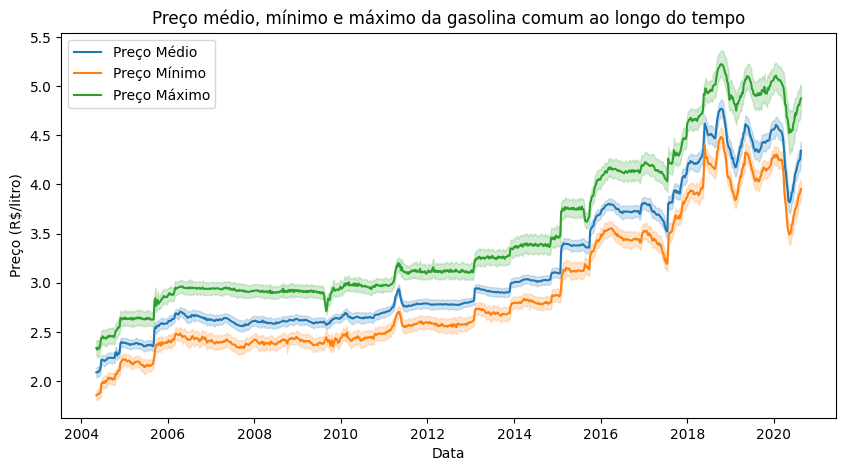

In [64]:
# Gráfico de Linha: Para visualizar como o preço médio, mínimo e máximo da gasolina comum variaram ao longo do tempo.
df_gasolina = df[df['produto'] == 'GASOLINA COMUM']
df_gasolina['data_inicial'] = pd.to_datetime(df['data_inicial'], format='%d/%m/%Y')
df_gasolina = df_gasolina.sort_values('data_inicial')

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_gasolina, x='data_inicial', y='preco_medio_final', label='Preço Médio')
sns.lineplot(data=df_gasolina, x='data_inicial', y='preco_min_final', label='Preço Mínimo')
sns.lineplot(data=df_gasolina, x='data_inicial', y='preco_max_final', label='Preço Máximo')
plt.xlabel('Data')
plt.ylabel('Preço (R$/litro)')
plt.title('Preço médio, mínimo e máximo da gasolina comum ao longo do tempo')
plt.legend()
plt.show()




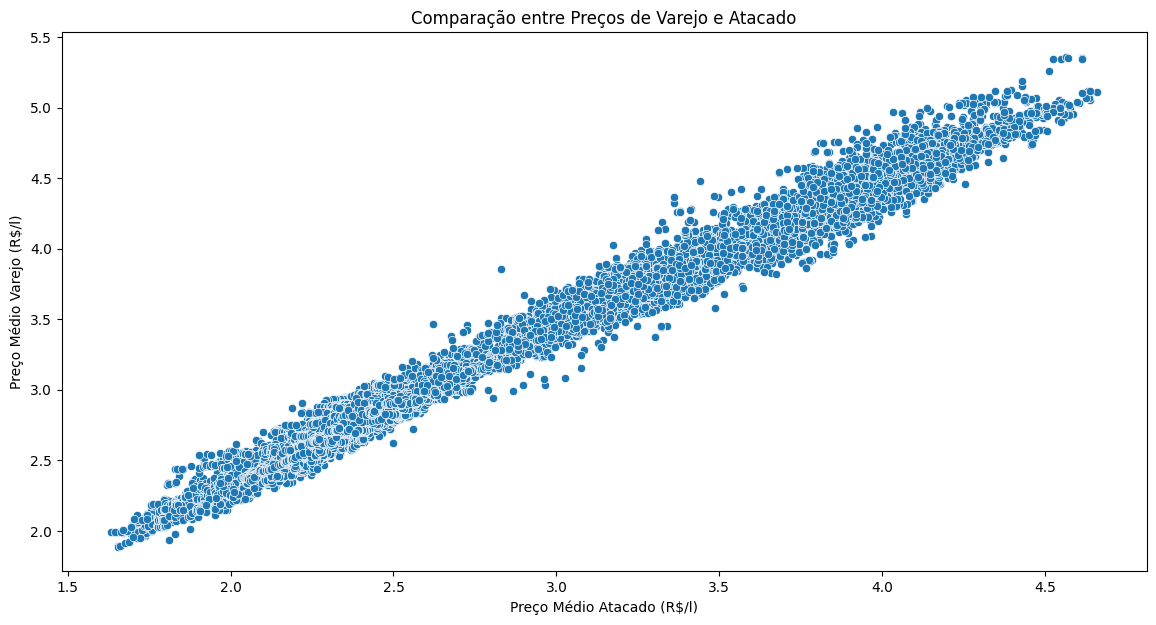

In [65]:
#Gráfico de Dispersão: Para comparar os preços médios de varejo e atacado.

plt.figure(figsize=(14, 7))
sns.scatterplot(data=df_gasolina, x='preco_medio_atacado', y='preco_medio_final')
plt.xlabel('Preço Médio Atacado (R$/l)')
plt.ylabel('Preço Médio Varejo (R$/l)')
plt.title('Comparação entre Preços de Varejo e Atacado')
plt.show()

In [56]:
# # Exportar o dataset em um arquivo Excel
# df.to_excel("./outputs/br_fuel_excel.xlsx", index=False)
